In [1]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
sales_train = pd.read_excel('Sales.xlsx', sheet_name='Train')

In [3]:
sales_test = pd.read_excel('Sales.xlsx', sheet_name='Test')

## Forecasting

In [4]:
# sales_train.set_index('Week',inplace=True)
sales_train = sales_train.drop(['Time'],axis=1)

In [6]:
states = list(sales_train['State'].unique())
# states

In [7]:
# sales_test.set_index('Week',inplace=True)
sales_test = sales_test.drop(['Time'],axis=1)

In [8]:
bookcode = [22722,22720,22979,84987]
states = list(sales_train['State'].unique())

In [45]:
def forecast(state,bookcode):
    sales_arizona = sales_train[sales_train['State']==state] #train df filtered on state
    sales_test_arizona = sales_test[sales_test['State']==state] #test df filtered on state

    arizona = sales_arizona[['Units Sold','Available Books in the shelf','Price','Week','BookCode']] #dropping the categorical columns
    arizona = arizona.sort_values(by=['Week']) # sorting by the dates
    arizona_book = arizona[arizona['BookCode']==bookcode] # filtering on the dates

    arizona_book = arizona_book.set_index('Week')
#     decomposition = sm.tsa.seasonal_decompose(pd.DataFrame(arizona_book,columns=['seasonal']), model='additive',freq=30)

    # test_stationary(arizona_book, window=12) #s.d. and rolling mean graph - ADF test
    # diff_12 = arizona_book.diff(periods=12)
    # diff_12.dropna(inplace=True) #first - differenced 
    # plt.plot(diff_12)
    # test_stationary(diff_12)

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    temp_model = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:        
    #         try:
            temp_model = sm.tsa.statespace.SARIMAX(arizona_book['Units Sold'],
                                          order = param,
                                          seasonal_order = param_seasonal,
                                          enforce_stationarity=True,
                                          enforce_invertibility=True)
            results = temp_model.fit()
            if results.aic < best_aic:
    #             print(results.aic)
              best_aic = results.aic
              best_pdq = param
              best_seasonal_pdq = param_seasonal
    #         except:
    #             continue

    # print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

    best_model = sm.tsa.statespace.SARIMAX(arizona_book['Units Sold'],
                                        order=best_pdq,
                                        seasonal_order=best_seasonal_pdq,
                                        enforce_stationarity=True,
                                        enforce_invertibility=True)
    best_results = best_model.fit()

    # print(best_results.summary().tables[0])

    pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2019-11-03'), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    
    arizona_test = sales_test_arizona[['Available Books in the shelf','Price','Week','BookCode']]
    arizona_test_book = arizona_test[arizona_test['BookCode']==bookcode]
    import datetime as dt
    arizona_test_book['Week_t'] = arizona_test_book['Week'].apply(lambda x: pd.Timestamp(x))
    arizona_test_book = arizona_test_book.set_index('Week_t')
    arizona_test_book.head()

    # Get forecast 8weeks ahead in future
    n_steps = 8
    pred_uc_8 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 95% CI

    # Get confidence intervals 95% of the forecasts
    pred_ci_8 = pred_uc_8.conf_int()

    forecast_data = pd.DataFrame(np.column_stack([pred_uc_8.predicted_mean, pred_ci_8]), 
                  index=arizona_test_book.index[:-1], columns=['forecast', 'lower_ci_8', 'upper_ci_8'])

    # forecast_data.head()
    return forecast_data

In [77]:
from tqdm import tqdm
df=pd.DataFrame()
for i in tqdm(states):
    try:
        for book in bookcode:
            forecast_data = forecast(i,book) 
            forecast_data['State'] = i
            forecast_data['BookCode'] = book
            df = df.append(forecast_data)
    except:
        continue

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [28:07<00:00, 80.36s/it]


In [78]:
df 

,forecast,lower_ci_8,upper_ci_8,State,BookCode
Week_t,,,,,
2019-11-03,4800.802417,4003.599181,5598.005653,Arizona,22722
2019-11-10,4974.217992,3745.335115,6203.100870,Arizona,22722
2019-11-17,4645.761568,3101.503866,6190.019271,Arizona,22722
2019-11-24,4571.644734,2766.288372,6377.001096,Arizona,22722
2019-12-01,4406.016821,2372.819509,6439.214134,Arizona,22722
...,...,...,...,...,...
2019-11-24,2665.782677,1829.838773,3501.726580,Wisconsin,84987
2019-12-01,2542.924542,1608.310845,3477.538239,Wisconsin,84987
2019-12-08,2572.110789,1548.292780,3595.928798,Wisconsin,84987


In [79]:
df = df.drop(['lower_ci_8','upper_ci_8'],axis =1)

In [80]:
df = df.rename(columns={'forecast':'Units Sold'})

In [81]:
df

,Units Sold,State,BookCode
Week_t,,,
2019-11-03,4800.802417,Arizona,22722
2019-11-10,4974.217992,Arizona,22722
2019-11-17,4645.761568,Arizona,22722
2019-11-24,4571.644734,Arizona,22722
2019-12-01,4406.016821,Arizona,22722
...,...,...,...
2019-11-24,2665.782677,Wisconsin,84987
2019-12-01,2542.924542,Wisconsin,84987
2019-12-08,2572.110789,Wisconsin,84987


In [82]:
df.to_csv('C:/Users/DuttaAnn/Downloads/scalathon/Advanced_Scalathon_dataset/Advanced_Scalathon_dataset/scalathon2021/scalathon2021/forecasted_values.csv',index=True)

## Processing

In [ ]:
sales_test.head(2)

In [ ]:
sales_train_categorical = sales_train.select_dtypes(include = 'object')
sales_test_categorical = sales_test.select_dtypes(include = 'object')

In [ ]:
sales_train_categorical.columns

In [ ]:
combined = pd.concat([sales_train_cat,sales_test_cat],ignore_index=True, sort = False)
categorical_cols = combined.columns

# Creating Label Encoded values for the categorical values avoid the dummy variable trap
dummies = pd.get_dummies(combined, columns=categorical_cols,  drop_first = True)


In [ ]:
# also the unique number of categorical values aren't same, which results in different test and train shape
train_len = sales_train.shape[0]

# Seperating the datasets from combined dataset
train_dummies = dummies[:train_len]
test_dummies = dummies[train_len:]

In [ ]:
# Concatenating with the main DataFrame
sales_train.reset_index(drop=True, inplace=True)
train_dummies.reset_index(drop=True, inplace=True)
df_train = pd.concat([sales_train,train_dummies],axis = 1)
print(df_train.shape)

In [ ]:
# Concatenating with the main DataFrame
sales_test.reset_index(drop=True, inplace=True)
test_dummies.reset_index(drop=True, inplace=True)
df_test = pd.concat([sales_test,test_dummies],axis = 1)
print(df_test.shape)

In [ ]:
df_train['Week'] = pd.to_datetime(df_train['Week'])
df_test['Week'] = pd.to_datetime(df_test['Week'])

In [ ]:
train = df_train.copy()
train = train.set_index('Week')

In [ ]:
test = df_test.copy()
test = test.set_index('Week')

In [ ]:
train = train.drop(['State'],axis=1)
test = test.drop(['State'],axis=1)

In [ ]:
train_df = train.reset_index()

In [ ]:
train_df = train_df.drop(['Week'],axis=1)

In [ ]:
train.head()

In [ ]:
##to decipher underlying patterns we must decompose the series.
decomposition = sm.tsa.seasonal_decompose(train, model='additive',period=7)

In [ ]:
def test_stationary(timeseries, window=12):
    
    # Rolling statistics
    movingAverage = timeseries.rolling(window=window).mean()
    movingSTD = timeseries.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(20,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation\n')
    plt.show(block=False)
    
    # Dickey Fuller test
    print('Results of Dickey Fuller Test:\n')
    dftest = adfuller(timeseries['Units Sold'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)


In [ ]:
test_stationary(train, window=12)

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(train, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(train, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

In [ ]:
train.head(2)

In [ ]:
sales_train['State'].nunique()

In [9]:
sales_arizona = sales_train[sales_train['State']=='California']

In [11]:
sales_test_arizona = sales_test[sales_test['State']=='California']

In [12]:
# sales_arizona.head()

In [13]:
arizona = sales_arizona[['Units Sold','Available Books in the shelf','Price','Week','BookCode']]

In [14]:
arizona = arizona.sort_values(by=['Week'])

In [15]:
arizona.head()

,Units Sold,Available Books in the shelf,Price,Week,BookCode
30667,4929.0,6456.990,4.587097,2017-07-09,52722
175,16430.0,21523.300,15.290323,2017-07-09,22722
43372,228992.4,318299.436,4.166937,2017-07-09,62979
40831,6572.0,8609.320,6.116129,2017-07-09,62722
38290,373276.2,403138.296,5.900270,2017-07-09,52720


In [16]:
arizona_plt = arizona[['Units Sold','Week']]
arizona_plt.head()

,Units Sold,Week
30667,4929.0,2017-07-09
175,16430.0,2017-07-09
43372,228992.4,2017-07-09
40831,6572.0,2017-07-09
38290,373276.2,2017-07-09


In [17]:
arizona_book = arizona[arizona['BookCode']==22722]
arizona_book.head()

,Units Sold,Available Books in the shelf,Price,Week,BookCode
175,16430.0,21523.30,15.290323,2017-07-09,22722
178,16089.0,27029.52,15.307601,2017-07-16,22722
181,15992.0,26706.64,15.479677,2017-07-23,22722
184,15563.0,20698.79,15.787059,2017-07-30,22722
187,19503.0,30034.62,15.138440,2017-08-06,22722


Text(0, 0.5, 'Units Sold')

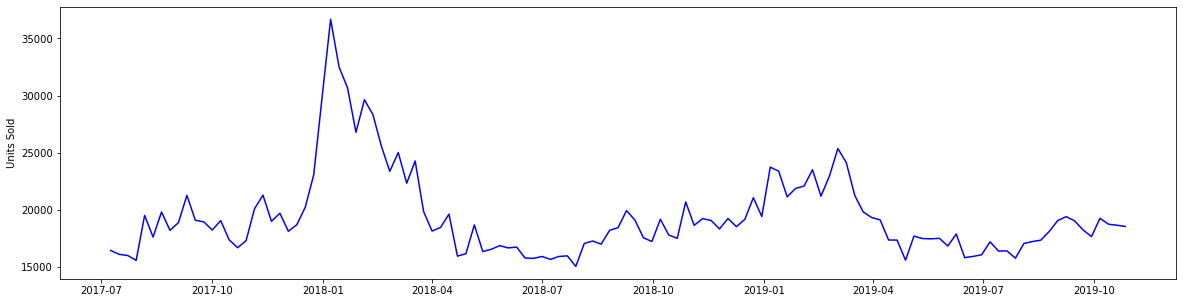

In [18]:
plt.figure(figsize=(20,5))
plt.plot(arizona_book['Week'],arizona_book['Units Sold'], color='blue')
plt.ylabel('Units Sold')

In [19]:
arizona_book = arizona_book.set_index('Week')

In [21]:
def test_stationary(timeseries, window=12):
    
    # Rolling statistics
    movingAverage = timeseries.rolling(window=window).mean()
    movingSTD = timeseries.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(20,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation\n')
    plt.show(block=False)
    
    # Dickey Fuller test
    print('Results of Dickey Fuller Test:\n')
    dftest = adfuller(timeseries['Units Sold'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

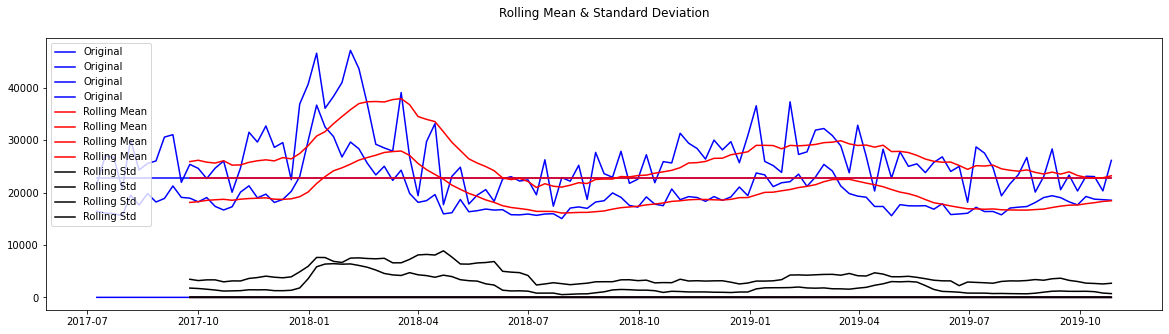

Results of Dickey Fuller Test:

Test Statistic                  -2.847996
p-value                          0.051738
No. of Lags used                 0.000000
Number of observations used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


In [22]:
test_stationary(arizona_book, window=12)

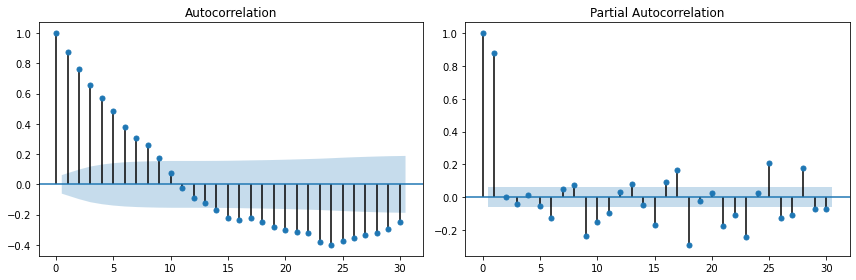

In [25]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(arizona_book['Units Sold'], lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(arizona_book['Units Sold'], lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

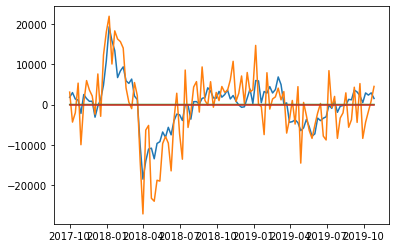

In [26]:
diff_12 = arizona_book.diff(periods=12)
diff_12.dropna(inplace=True)

plt.plot(diff_12)

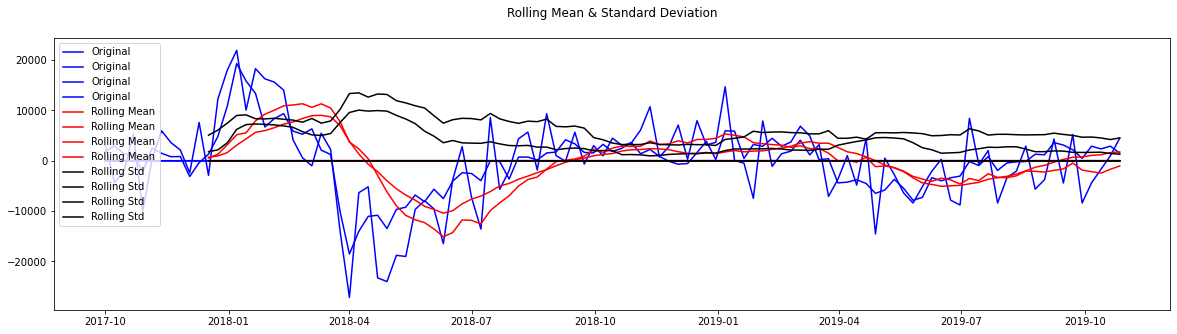

Results of Dickey Fuller Test:

Test Statistic                 -2.331601
p-value                         0.161979
No. of Lags used               12.000000
Number of observations used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


In [27]:
test_stationary(diff_12)

In [28]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [29]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [30]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [31]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:        
#         try:
        temp_model = sm.tsa.statespace.SARIMAX(arizona_book['Units Sold'],
                                         order = param,
                                         seasonal_order = param_seasonal,
                                         enforce_stationarity=True,
                                         enforce_invertibility=True)
        results = temp_model.fit()
        if results.aic < best_aic:
#             print(results.aic)
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
#         except:
#             continue

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 0)x(0, 1, 1, 12)12 model - AIC:1964.459725914417


In [33]:
# best_pdq = (0, 1, 1)
best_seasonal_pdq# = (1, 1, 1, 12)

(1, 1, 1, 12)

In [34]:
best_model = sm.tsa.statespace.SARIMAX(arizona_book['Units Sold'],
                                      order=best_pdq,
                                      seasonal_order=best_seasonal_pdq,
                                      enforce_stationarity=True,
                                      enforce_invertibility=True)
best_results = best_model.fit()

In [35]:
print(best_results.summary().tables[0])

                                     SARIMAX Results                                      
Dep. Variable:                         Units Sold   No. Observations:                  121
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -980.061
Date:                            Thu, 18 Mar 2021   AIC                           1968.123
Time:                                    01:20:24   BIC                           1978.851
Sample:                                07-09-2017   HQIC                          1972.473
                                     - 10-27-2019                                         
Covariance Type:                              opg                                         


In [43]:
arizona_test = sales_test_arizona[['Available Books in the shelf','Price','Week','BookCode']]
arizona_test_book = arizona_test[arizona_test['BookCode']==22722]
import datetime as dt
arizona_test_book['Week_t'] = arizona_test_book['Week'].apply(lambda x: pd.Timestamp(x))
arizona_test_book = arizona_test_book.set_index('Week_t')
arizona_test_book.head()

,Available Books in the shelf,Price,Week,BookCode
Week_t,,,,
2019-11-03,23642.0,15.175953,2019-11-03,22722
2019-11-10,37342.0,14.844835,2019-11-10,22722
2019-11-17,31023.0,15.010182,2019-11-17,22722
2019-11-24,33306.0,14.874520,2019-11-24,22722
2019-12-01,31839.0,15.081353,2019-12-01,22722


In [36]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2019-11-03'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [37]:
arizona_book_pred = pred_dynamic.predicted_mean
# arizona_book_truth = arizona_book['1990':].Precipitation

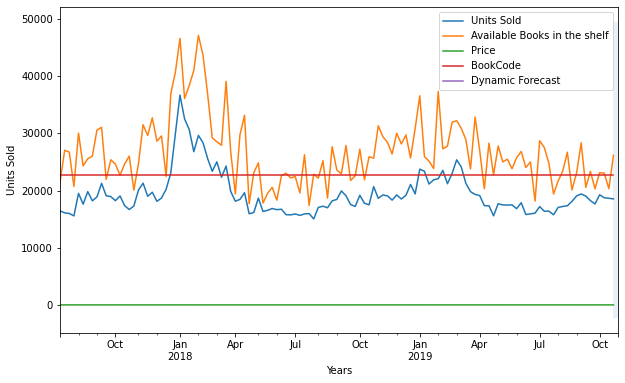

In [38]:
axis_plt = arizona_book['2017-07-09':].plot(label='Observed', figsize=(10, 6))

# Plot the predicted values.
pred_dynamic.predicted_mean.plot(ax=axis_plt, label='Dynamic Forecast')

# Plot confidence values and fill it with some colour.
axis_plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.1)
axis_plt.fill_betweenx(axis_plt.get_ylim(), pd.to_datetime('2019-11-03'), arizona_book.index[-1], alpha=0.1, zorder=-1)

# Set labels.
axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Units Sold')

# Put legend on the plot at the best place it fits.
plt.legend(loc='best')

In [39]:
# Get forecast 96 steps (8 years) ahead in future
n_steps = 8
pred_uc_8 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% of the forecasts
pred_ci_8 = pred_uc_8.conf_int()

In [44]:
# index = pd.date_range(arizona_test_book.index, periods=n_steps)
forecast_data = pd.DataFrame(np.column_stack([pred_uc_8.predicted_mean, pred_ci_8]), 
                     index=arizona_test_book.index[:-1], columns=['forecast', 'lower_ci_8', 'upper_ci_8'])

forecast_data.head()


,forecast,lower_ci_8,upper_ci_8
Week_t,,,
2019-11-03,19183.402553,15270.310554,23096.494552
2019-11-10,19578.202598,14181.393113,24975.012082
2019-11-17,18961.044241,12408.273593,25513.814889
2019-11-24,19307.934673,11774.538813,26841.330533
2019-12-01,18418.557239,10018.241579,26818.872899


In [ ]:
plt.figure(figsize=(20,5))
plt.plot(forecast_data.index,forecast_data['forecast'], color='blue')
# plt.ylabel('Units Sold')